# Contexto

![ifood](https://imagens.ne10.uol.com.br/veiculos/_midias/jpg/2021/11/02/806x444/1_capturar-19381193.jpg)

Dados públicos de abril/21 - Em 2021, a empresa atingiu uma nova marca de 60 milhões de pedidos mensais.  
Crescimento de 100% em um ano; mais de 110.000 restaurantes se inscreveram na plataforma nos últimos 12 meses.  
Só em março, o mês mais letal da pandemia para o Brasil, 270 mil restaurantes operavam com a plataforma iFood.  

Fonte: [labsnews.com/en/articles/business/ifood-60-million-monthly-orders-amid-the-pandemic/](labsnews.com/en/articles/business/ifood-60-million-monthly-orders-amid-the-pandemic/)

Quando o assunto é popularidade, o iFood segue sendo o aplicativo mais citado pelos respondentes, com 91,6% de citações.

Fonte: [exame.com/negocios/nps-ifood-e-melhor-e-mais-popular-app-de-delivery-diz-pesquisa/](exame.com/negocios/nps-ifood-e-melhor-e-mais-popular-app-de-delivery-diz-pesquisa/)

A diversidade e amplitude de clientes que utilizam a plataforma do iFood é gigante - a cobertura do aplicativo se  
estende por muitas geografias no Brasil, de múltiplos gostos, regionalismos e bolsos. Alguns buscam uma experiência  
no momento da refeição, outros só querem receber a marmita na hora certa para não se atrasar para a primeira reunião pós-almoço.  


# Objetivo

Neste contexto, esse notebook visa explorar os dados para entender melhor os perfis de clientes do iFood para responder as seguintes perguntas:  
Quem é o mais fiel e quem mais compra na plataforma?  
Quem mais gosta de cupom?  
Quem gosta de entrega grátis?  
Qual o padrão de consumo?  
Qual o padrão de comportamento?  
Quanto os clientes vão gastar? Onde?

Para isso, serão usadas técnicas de aprendizado não supervisionado. Este documento é dividido da seguinte forma:  

* Análise exploratória dos dados  
* Pré-processamento dos dados  
* Implementação e análise do modelo  
* Conclusões  

Para esse estudo foram disponibilizados três datasets, são eles "Marketing", "Orders" e "sessions".  
Como o objetivo é caracterizar o perfil dos clientes, o dataset "sessions" que contém dados de sessões no aplicativo não será utilizado.  

As linhas de código abaixo carregam as bibliotecas necessárias e a base de dados para o estudo.

In [1]:
import pandas as pd
import  numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from kmodes.kprototypes import KPrototypes

In [2]:
marketing_df = pd.read_table('data/Marketing.xls', sep=';')
orders_df = pd.read_table('data/Orders.xls', sep=';')

# Análise exploratória dos dados  

Nesta seção serão exploradas as características básicas dos datasets, como dimensões e variáveis.  

### **marketing_df**:  

Este dataset apresenta informações sobre o uso da plataforma pelos clientes. Contendo 20249 linhas e 6 colunas, cada linha representa um cliente e cada coluna uma característica de uso, detalhadas abaixo:  

* **account_id**: ID do usuário (categórica)   
* **registration_date**: Data de registro da conta (categórica)  
* **ifood_status_last_month**: Situação do cliente na plataforma no mês anterior (categórica)  
* **ifood_status**: Situação atual do cliente na plataforma (categórica)  

    Tanto para a coluna **ifood_status_last_month** tanto para **ifood_status**, os valores podem ser os seguintes:

    - **Active**: O cliente tem um pedido concluído no mês atual e não é "Reactivated".
    - **Inactive**: O cliente tem um primeiro pedido concluído, mas não esteve ativo no mêss atual e no mês passado.
    - **Churn**: O cliente tem pedidos concluídos no mês passado, mas ainda não fez nenhum pedido no mês atual.
    - **Reactivated**: O cliente tem um pedido concluído no mês atual, mas nenhum pedido no mês passado e não é um novo cliente.
    - **Prospect**: O cliente ainda não fez o primeiro pedido.
    - **New**: Primeiro pedido concluído feito no mês atual.  

    
* **total_order_count**: Total de pedidos feitos pelo cliente (numérica)
* **first_order_date**: Data do primeiro pedido feito pelo cliente (categórica)  

In [3]:
marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_id               20249 non-null  object
 1   registration_date        20249 non-null  object
 2   ifood_status             20249 non-null  object
 3   ifood_status_last_month  20249 non-null  object
 4   total_order_count        20249 non-null  int64 
 5   first_order_date         20248 non-null  object
dtypes: int64(1), object(5)
memory usage: 949.3+ KB


In [4]:
marketing_df.ifood_status.value_counts()

ifood_status
Active         11648
Inactive        4805
Churn           3355
Reactivated      440
Prospect           1
Name: count, dtype: int64

In [5]:
marketing_df.ifood_status_last_month.value_counts()

ifood_status_last_month
Active         14080
Inactive        4583
Reactivated      922
Churn            662
New                1
Prospect           1
Name: count, dtype: int64

O código abaixo apresenta uma amostra dos dados:

In [6]:
marketing_df.head()

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12


In [7]:
marketing_df.isna().mean()*100

account_id                 0.000000
registration_date          0.000000
ifood_status               0.000000
ifood_status_last_month    0.000000
total_order_count          0.000000
first_order_date           0.004939
dtype: float64

Ao avaliar a integridade dos dados, verifica-se que a variável "first_order_date" possui 0,0049% dos dados faltantes.  

#### Explorando a variável numérica

O código abaixo obtem as estatísticas descritivas da variável númerica "total_order_count". Essa variável aparenta possuir outliers, valores que usualmente não deveriam aparecer, pois os valores máximos estão muito superiores ao percentil de 99%. Um outro indicativo disso é que a média de pedidos por cliente é de 341, porém o desvio padrão é de 303 pedidos, sendo um valor muito alto, provavelmente devido a influência dos outliers.
Através do histograma é apresentada uma representação visual da distribuição de pedidos.

In [8]:
marketing_df['total_order_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.99])

count    20249.000000
mean       341.321201
std        303.150112
min          0.000000
25%         91.000000
50%        286.000000
75%        501.000000
99%       1329.040000
max       3098.000000
Name: total_order_count, dtype: float64

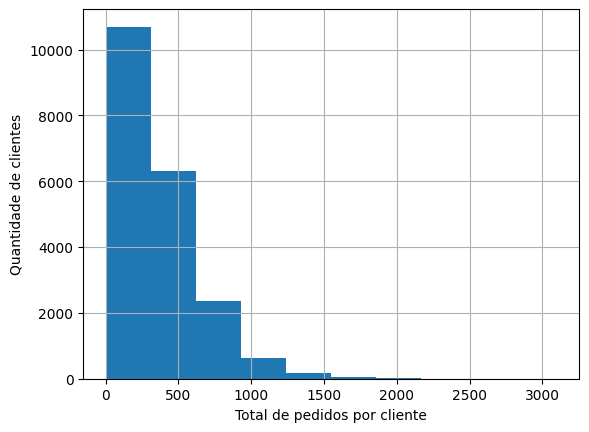

In [9]:
marketing_df['total_order_count'].hist()
plt.xlabel('Total de pedidos por cliente')
plt.ylabel('Quantidade de clientes')
plt.show()

#### Explorando as variáveis categóricas

O código abaixo mostra que o número de usuários ativos na plataforma caiu 17% em relação ao mês anterior,  
a possibilidade de churn aumentou em 406% e o número de contas que foram reativadas caiu 52%,  
ao passo que não houve nenhum novo cliente no mês atual.

In [10]:
current_status = marketing_df['ifood_status'].value_counts(normalize=True)
current_status*100

ifood_status
Active         57.523828
Inactive       23.729567
Churn          16.568719
Reactivated     2.172947
Prospect        0.004939
Name: proportion, dtype: float64

In [11]:
last_month_status = marketing_df['ifood_status_last_month'].value_counts(normalize=True)
last_month_status*100

ifood_status_last_month
Active         69.534298
Inactive       22.633216
Reactivated     4.553311
Churn           3.269297
New             0.004939
Prospect        0.004939
Name: proportion, dtype: float64

In [12]:
((current_status - last_month_status) / last_month_status) * 100

Active         -17.272727
Churn          406.797583
Inactive         4.843989
New                   NaN
Prospect         0.000000
Reactivated    -52.277657
Name: proportion, dtype: float64

Anteriormente verificou-se que a variável "first_order_date" possui apenas 0,0049% de dados faltantes. Como é um valor baixo em relação ao todo, tomou-se a decisão de removê-las do dataset.

In [13]:
isnull_count = (marketing_df[marketing_df['first_order_date'].isnull()].shape[0]*100)/marketing_df.shape[0]

print("Apenas {:.4f}% das linhas contém dados faltantes.".format(isnull_count))

Apenas 0.0049% das linhas contém dados faltantes.


In [14]:
marketing_df_mis = marketing_df.dropna()
marketing_df_mis.isna().mean()*100

account_id                 0.0
registration_date          0.0
ifood_status               0.0
ifood_status_last_month    0.0
total_order_count          0.0
first_order_date           0.0
dtype: float64

### **orders_df**:  

Este dataset apresenta informações sobre os pedidos realizados na plataforma. Contendo 226269 linhas e 34 colunas, cada linha representa um pedido e cada coluna uma característica do pedido, detalhadas abaixo:  

* **order_id**: ID único para pedido (categórica)   
* **order_shift**: Dia e período do dia que foi realizado o pedido (categórica)  
* **order_origin**: Tipo do Merchant (categórica)  
* **delivery_fee**: Taxa de entrega paga pelo cliente (numérica)    
* **scheduled**: Booleano que indica se o pedido foi agendado (booleano)
* **total_amount**: Valor total pago pelo cliente (em Unidades Monetárias UM) (numérica)  
* **subsidy_amount**: Subsídio, desconto dado no pedido (em Unidades Monetárias UM)  
(para o valor final total do pedido: total_amount + subsidy) (numérica)  
* **device_platform**: Plataforma (sistema operacional) utilizado para fazer o pedido (ANDROID, DESKTOP, etc) (categórica)  
* **device_type**: Canal de origem do pedido (SITE, MOBILE, etc) (categórica)  
* **device_app_version**: Versão do aplicativo do iFood que fez o pedido (categórica)  
* **centroid_id**: Id da centroide do clientes (categórica)  
* **state_label**: Sigla da UF do cliente (categórica)  
* **city**: Cidade do cliente (categórica)  
* **district**: Bairro do cliente (categórica)  
* **customer_long**: Longitude do cliente (até 2ª casa decimal) - ~1km (numérica)  
* **customer_lat**: Latitude do cliente (até 2ª casa decimal) - ~1km (numérica)  
* **restaurant_id**: Identificador do restaurante (categórica)  
* **dish_type**: Tipo de cozinha (categórica)  
* **group_id**: Se o restaurante fizer parte de um grupo, essa é a identificação do grupo (categórica)  
* **merchant_centroid_id**: Id da centroide (categórica)  
* **merchant_state**: Sigla do UF do Merchant (categórica)  
* **merchant_city**: Cidade do Merchant (categórica)  
* **merchant_district***: Distrito do Merchant (categórica)  
* **merchant_zipcode**: CEP do Merchant (numérica)  
* **merchant_long**: Longitude do Merchant (até 2ª casa decimal) (numérica)  
* **merchant_lat**: Latitude do Merchant (até 2ª casa decimal) (numérica)  
* **has_free_delivery**: Booleano que indica se o pedido foi entrega gratis (categórica)  
* **confirmed_date**: Data que o pedido foi confirmado pelo restaurante (datetime)  
* **concluded_date**: Data em que o pedido foi concluído (datetime)  
* **lag_last_order**: Tempo em dias entre o pedido atual e o último pedido do cliente (numérica)  
* **account_id**: ID do usuário (categórica)  

In [15]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  bool   
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  centroid_id           226269 non-null  object 
 11  state_label           226269 non-null  object 
 12  city                  226269 non-null  object 
 13  district              226269 non-null  object 
 14  customer_long         226269 non-null  float64
 15  

O código abaixo é usado para verificar as categorias de cada variável categórica desse dataset.

In [16]:
for column in orders_df.columns:
    if orders_df[column].dtype == 'object':
        print("variável:")
        print(orders_df[column].value_counts())

variável:
order_id
000f4c94-ec38-488b-ad98-9bf3ea19d517    1
11c68cd1-0e71-49b1-aa10-d2d5585f6f90    1
0f813802-a0c3-4989-ba7d-c6e2dce2ec1e    1
0f9547fd-2cb4-4bf9-b70f-80a06974d82c    1
10810555-50f0-4929-b51d-7d476d143222    1
                                       ..
b0af6537-51b6-45f5-ac8d-363bb5992d61    1
b0afdc9a-7d2b-4742-b6d9-bb6307ad8cd7    1
b1145f54-b104-4f4f-bc62-71e2c4fd8230    1
b17e8128-89ac-475d-b3e4-eaaa85a8af78    1
ff72056f-0530-4d33-9180-b9b735817edb    1
Name: count, Length: 226269, dtype: int64
variável:
order_shift
weekday lunch        58433
weekday dinner       53720
weekend dinner       50821
weekend lunch        22782
weekday snack        13382
weekday breakfast    12358
weekend snack         5909
weekday dawn          3828
weekend dawn          3329
weekend breakfast     1707
Name: count, dtype: int64
variável:
order_origin
RESTAURANT      219886
STORE             4798
QUICKLY_MEAL      1585
Name: count, dtype: int64
variável:
device_platform
ANDROID    1181

O código abaixo apresenta uma amostra do dataset:

In [17]:
orders_df.head(2)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,...,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,...,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.0,IOS,MOBILE,9.63.0,...,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z


A verificação de possíveis valores faltantes no dataset é feita usando a biblioteca "missingno" para um resultado visual  
e o método "isna" do Pandas para os valores em porcentagem.  
Esse dataset possui 4 variáveis com valores faltantes, sendo a variável "device_app_version" a que apresentou o maior percentual, com 1.96%. 

<Axes: >

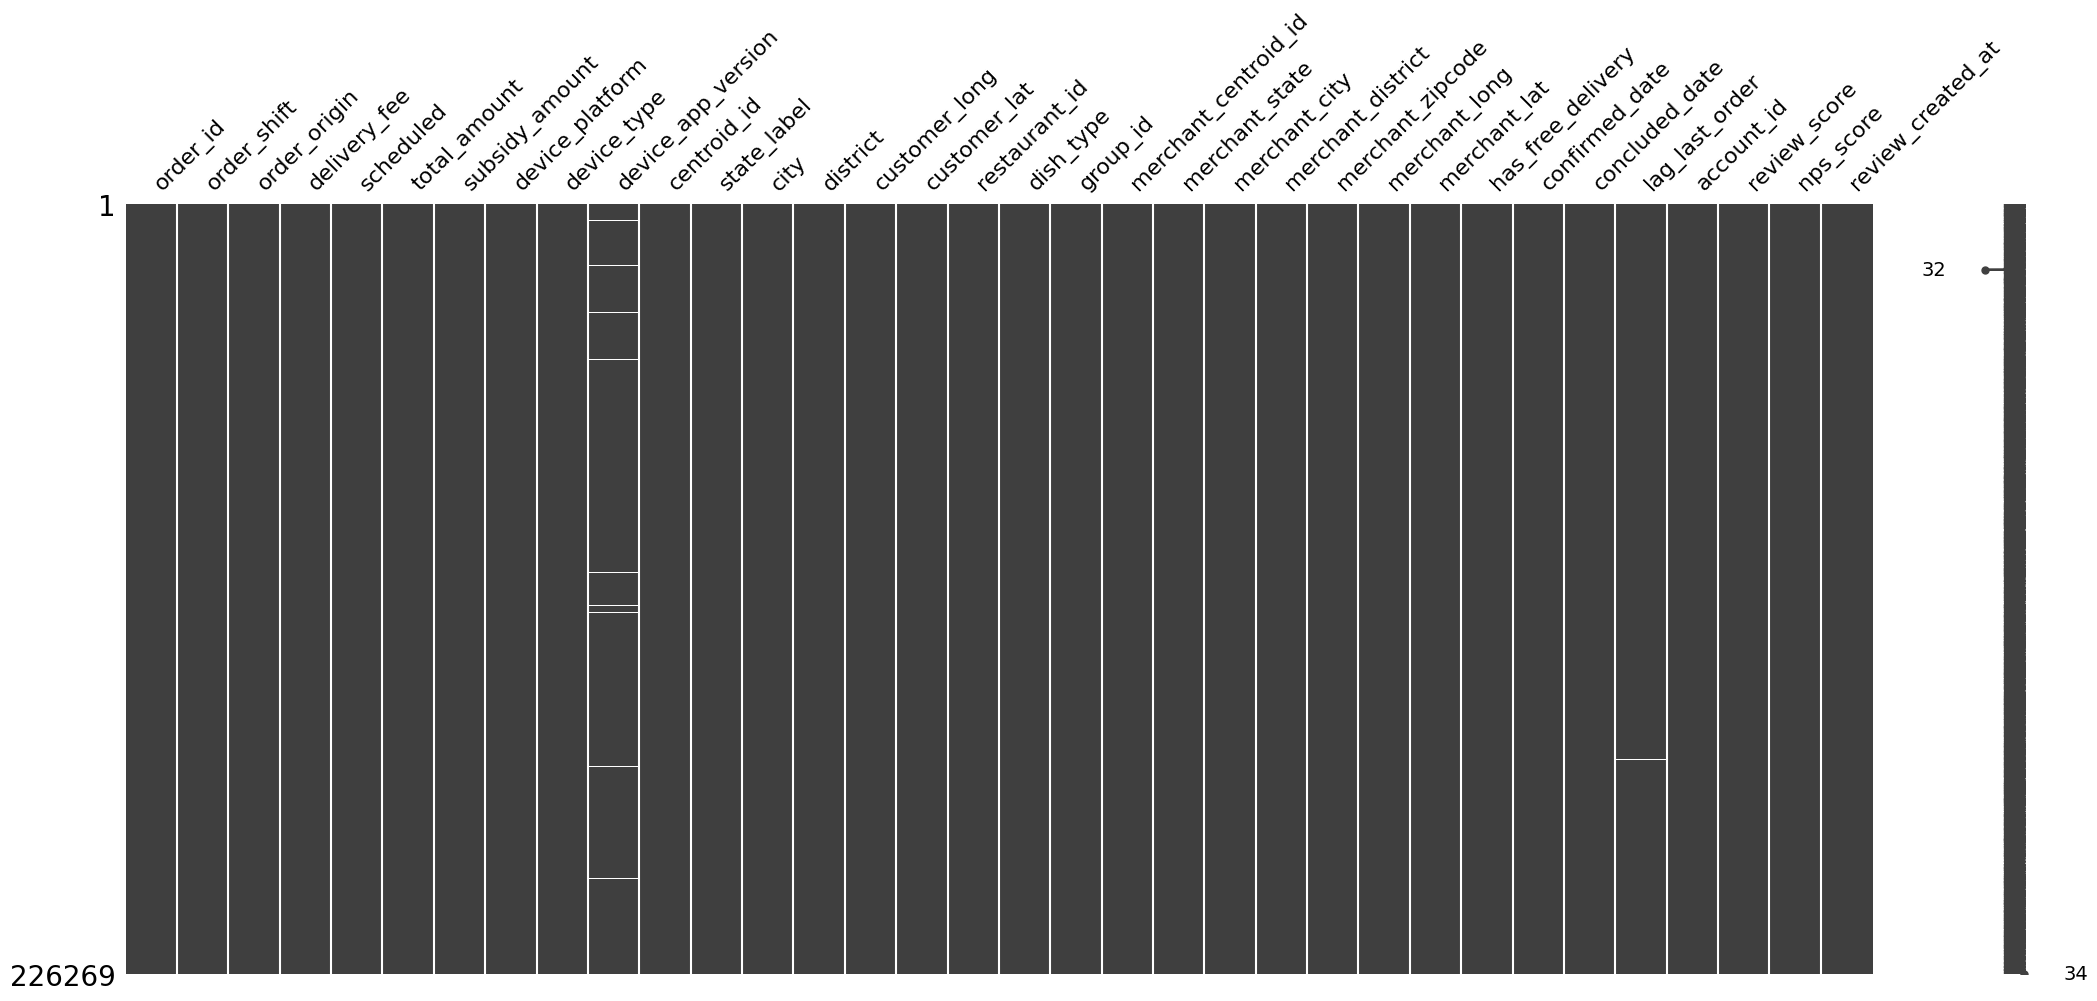

In [18]:
msno.matrix(orders_df)

In [19]:
orders_df.isna().mean().sort_values(ascending=False)*100

device_app_version      1.960056
lag_last_order          0.081319
confirmed_date          0.006187
concluded_date          0.001768
order_id                0.000000
merchant_long           0.000000
merchant_state          0.000000
merchant_city           0.000000
merchant_district       0.000000
merchant_zipcode        0.000000
has_free_delivery       0.000000
merchant_lat            0.000000
group_id                0.000000
account_id              0.000000
review_score            0.000000
nps_score               0.000000
merchant_centroid_id    0.000000
dish_type               0.000000
order_shift             0.000000
restaurant_id           0.000000
customer_lat            0.000000
customer_long           0.000000
district                0.000000
city                    0.000000
state_label             0.000000
centroid_id             0.000000
device_type             0.000000
device_platform         0.000000
subsidy_amount          0.000000
total_amount            0.000000
scheduled 

#### Explorando as variáveis numéricas

Para ser possível explorar as variáveis númericas, essas foram separadas dos outros tipos de variáveis do banco de dados.
O código abaixo apresenta um resumo das variáveis numéricas do banco de dados. A variável "merchant_zipcode" foi excluída do resumo  
pois apesar de ser numérica, os valores são números de CEP.  
As variáveis "review_score" e "nps_score" serão apresentadas apenas com seus valores de média e desvio padrão pois trata-se de score.
Nota-se que as variáveis numéricas não estão na mesma escala, logo os dados precisarão ser normalizados em etapas posteriores.

In [20]:
numeric_cols = []

for column in orders_df.columns:
    if orders_df[column].dtype == 'float64' or orders_df[column].dtype == 'int64':
        numeric_cols.append(column)

print(numeric_cols)

['delivery_fee', 'total_amount', 'subsidy_amount', 'customer_long', 'customer_lat', 'merchant_zipcode', 'merchant_long', 'merchant_lat', 'lag_last_order', 'review_score', 'nps_score']


In [21]:
orders_df[numeric_cols].drop(['merchant_zipcode', 'review_score', 'nps_score'], axis=1).describe(percentiles=[0.25, 0.50, 0.75, 0.99]).T

,count,mean,std,min,25%,50%,75%,99%,max
delivery_fee,226269.0,405.418965,504.026635,-1247.50,0.00,0.00,748.75,1748.75,5000.00
total_amount,226269.0,6017.809350,5180.780032,0.00,2768.75,4500.00,7523.75,25236.65,174873.75
subsidy_amount,226269.0,343.687580,677.852181,-2.50,0.00,0.00,623.75,2987.50,19611.25
customer_long,226269.0,-45.693016,2.184032,-67.87,-46.71,-46.62,-43.35,-41.31,-34.82
customer_lat,226269.0,-23.192878,2.206372,-31.78,-23.60,-23.53,-22.94,-9.65,2.85
merchant_long,226269.0,-45.692937,2.194552,-67.84,-46.70,-46.62,-43.35,-41.32,46.79
merchant_lat,226269.0,-23.193716,2.206171,-31.78,-23.60,-23.54,-22.95,-9.65,2.85
lag_last_order,226085.0,2.505275,11.985040,0.00,0.00,1.00,2.00,27.00,1429.00


Na tabela de percentis apresentada acima nota-se valores negativos para a variável 'delivery_fee' que corresponde a taxa de entrega. Ao analisar mais profundamente, verifica-se que apenas um dos dados possui valor negativo, logo, toma-se a decisão de excluir esse dado já que não é aceitável valor negativo para taxa de entrega.

In [22]:
orders_df[orders_df['delivery_fee'] < 0]['delivery_fee'].value_counts()

delivery_fee
-1247.5    1
Name: count, dtype: int64

In [23]:
orders_df = orders_df.drop(orders_df.index[orders_df['delivery_fee'] < 0])

In [24]:
orders_df[orders_df['subsidy_amount'] < 0]['subsidy_amount'].value_counts()

subsidy_amount
-1.25    5532
-2.50       5
Name: count, dtype: int64

Já a variável "subsidy_amount" contém 2.45% de dados com valores negativos, como não faz sentido valores de desconto negativos para essa variável  
e a porcentagem é baixa, tomou-se a decisão de excluir esses dados do banco de dados.

In [25]:
subsidy_neg_percentage = (orders_df[orders_df['subsidy_amount'] < 0]['subsidy_amount'].value_counts().sum() / orders_df.shape[0]) * 100
print("o número de dados com valores negativos da variável 'subsidy_amount' corresponde a {:.2f}% do valor total de dados."
      .format(subsidy_neg_percentage))

o número de dados com valores negativos da variável 'subsidy_amount' corresponde a 2.45% do valor total de dados.


In [26]:
orders_df = orders_df.drop(orders_df.index[orders_df['subsidy_amount'] < 0])

In [27]:
review_score_mean = orders_df['review_score'].mean()
review_score_std = orders_df['review_score'].std()
print ("A média da variável 'review_score' é {:.2f} e seu desvio padrão é {:.2f}.".format(review_score_mean, review_score_std))

A média da variável 'review_score' é 4.67 e seu desvio padrão é 0.93.


In [28]:
nps_score_mean = orders_df['nps_score'].mean()
nps_score_std = orders_df['nps_score'].std()
print ("A média da variável 'nps_score' é {:.2f} e seu desvio padrão é {:.2f}.".format(nps_score_mean, nps_score_std))

A média da variável 'nps_score' é 9.10 e seu desvio padrão é 1.90.


Anteriormente verificou-se que esse banco de dados possui quatro variáveis com valores faltantes, sendo a maior delas com 1,96%. Como é um valor pequeno em relação ao todo, tomou-se a decisão de remover esses dados.

In [29]:
orders_df_mis = orders_df.dropna()

In [30]:
orders_df_mis.isna().mean()*100

order_id                0.0
order_shift             0.0
order_origin            0.0
delivery_fee            0.0
scheduled               0.0
total_amount            0.0
subsidy_amount          0.0
device_platform         0.0
device_type             0.0
device_app_version      0.0
centroid_id             0.0
state_label             0.0
city                    0.0
district                0.0
customer_long           0.0
customer_lat            0.0
restaurant_id           0.0
dish_type               0.0
group_id                0.0
merchant_centroid_id    0.0
merchant_state          0.0
merchant_city           0.0
merchant_district       0.0
merchant_zipcode        0.0
merchant_long           0.0
merchant_lat            0.0
has_free_delivery       0.0
confirmed_date          0.0
concluded_date          0.0
lag_last_order          0.0
account_id              0.0
review_score            0.0
nps_score               0.0
review_created_at       0.0
dtype: float64

#### Explorando as variáveis categóricas

Para avaliar as variáveis categóricas do banco de dados "orders", esas serão separadas das variáveis numéricas.

In [31]:
categoric_cols = list(set(orders_df_mis.columns) - set(numeric_cols))
categoric_cols

['order_shift',
 'order_origin',
 'state_label',
 'concluded_date',
 'device_app_version',
 'merchant_state',
 'has_free_delivery',
 'merchant_city',
 'city',
 'account_id',
 'order_id',
 'merchant_centroid_id',
 'device_platform',
 'group_id',
 'dish_type',
 'district',
 'merchant_district',
 'restaurant_id',
 'scheduled',
 'device_type',
 'confirmed_date',
 'review_created_at',
 'centroid_id']

Para realizar uma análise descritiva das variáveis categóricas, foi utilizado o método "describe".  
Ao analisar os resultados, é possível ver que a cidade de São Paulo é onde teve o maior número de pedidos, com 50,54%, correspondendo a 109.321 pedidos do total de 216.316. Também verifica-se que o número de pedidos agendados é muito baixo, sendo 2.56% dos pedidos realizados.  
A categoria de comida mais pedida é Lanches e a origem dos pedidos é de restaurantes. Nota-se também a preferência por lugares com entrega  
grátis, sendo 53.94% dos pedidos.
A respeito da plataforma utilizada para fazer os pedidos, a mais comum é celulares do tipo android.

In [32]:
orders_df_mis[categoric_cols].describe()

,order_shift,order_origin,state_label,concluded_date,device_app_version,merchant_state,has_free_delivery,merchant_city,city,account_id,...,group_id,dish_type,district,merchant_district,restaurant_id,scheduled,device_type,confirmed_date,review_created_at,centroid_id
count,216316,216316,216316,216316,216316,216316,216316,216316,216316,216316,...,216316,216316,216316,216316,216316,216316,216316,216316,216316,216316
unique,10,3,27,216258,211,27,2,325,314,13772,...,3479,61,4393,7504,37610,2,2,216296,216316,4108
top,weekday lunch,RESTAURANT,SP,2020-02-05T15:31:17.460Z,9.37.1,SP,True,SAO PAULO,SAO PAULO,d300ac6b-3fd5-4f24-b80e-a2a0066f925c,...,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,Lanches,Vila Mariana,Centro,cc6f3a7a83faf0c0ce4e7ec414b1b1b29aedfce9143a67...,False,MOBILE,2020-08-05T13:19:04.707Z,2020-02-28T19:06:31.861Z,-23.59-46.75
freq,55721,209989,123338,3,8865,123350,116680,107754,109321,611,...,139873,42731,3676,3305,391,210778,197928,2,1,2538


In [33]:
most_freq_order_city_perc = ( orders_df_mis[orders_df_mis['city'] == 'SAO PAULO'].value_counts().sum() / orders_df_mis.shape[0] ) * 100
print("A cidade de São Paulo corresponde a {:.2f}% dos pedidos realizados.".format(most_freq_order_city_perc))

A cidade de São Paulo corresponde a 50.54% dos pedidos realizados.


In [34]:
scheduled_freq_perc = ( orders_df_mis[orders_df_mis['scheduled'] == True].value_counts().sum() / orders_df_mis.shape[0] ) * 100
print("O percentual de pedidos agendados corresponde a {:.2f}% dos pedidos realizados.".format(scheduled_freq_perc))

O percentual de pedidos agendados corresponde a 2.56% dos pedidos realizados.


In [35]:
has_free_delivery_perc = ( orders_df_mis[orders_df_mis['has_free_delivery'] == True].value_counts().sum() / orders_df_mis.shape[0] ) * 100
print("O percentual de pedidos com entrega grátis é de {:.2f}%.".format(has_free_delivery_perc))

O percentual de pedidos com entrega grátis é de 53.94%.


#### Pré-processamento de dados

A partir da análise exploratória dos dados e das perguntas que foram definidas no objetivo, definiu-se as seguintes variáveis para realizar a clusterização:

* ifood_status  
* ifood_status_last_month  
* total_order_count  
* city   
* lag_last_order  
* subsidy_amount  
* has_free_delivery  
* dish_type  
* order_origin  
* total_amount

O banco de dados "orders_df_mis" possui 13772 usuários únicos com um total de 216.316 pedidos.  
Como existe mais de um pedido por cliente, cada cliente será caracterizado pelos valores mais frequentes nas variáveis categóricas e com a mediana nas variáveis numéricas.


In [36]:
print("O banco de dados possui {} pedidos.".format(len(orders_df_mis)))

O banco de dados possui 216316 pedidos.


In [37]:
orders_df_mis['account_id'].value_counts()

account_id
d300ac6b-3fd5-4f24-b80e-a2a0066f925c    611
6415a86b-cb49-4586-880c-d0ba667d3a3d    565
4091f823-a717-4bbc-a015-a0ddaf6f8235    558
01977262-3113-4279-8c12-688cf17de335    530
51722130-363f-42aa-bef0-70e46434eba9    479
                                       ... 
ae72530b-b331-41d0-beff-343795df4cac      1
b75346f1-2c7d-41a4-a392-7dada9b93831      1
1192897d-1e75-46ef-9fef-2d09e9bc962c      1
f6fe2a1a-9453-43fa-961b-41bfb3b16070      1
4937ef9f-ce1c-41e3-85ba-deb77a185124      1
Name: count, Length: 13772, dtype: int64

Os agrupamentos dos dados de cada cliente dos banco de dados "orders_df_mis" e "marketing_df_mis" são feitos nos código abaixo. É usada uma função lambda para determinar o valor mais frequente das variáveis categóricas.

In [38]:
order_by_customer_df = orders_df_mis.groupby(by='account_id',as_index=False).agg(
                                            order_origin= ('order_origin', lambda num: num.value_counts().index[0]),
                                            total_amount= ('total_amount', 'median'),
                                            subsidy_amount= ('subsidy_amount', 'median'),
                                            city= ('city', lambda num: num.value_counts().index[0]),
                                            dish_type= ('dish_type', lambda num: num.value_counts().index[0]),
                                            has_free_delivery = ('has_free_delivery', lambda num: num.value_counts().index[0]),
                                            lag_last_order= ('lag_last_order', 'median')

)


In [39]:
marketing_by_customer_df = marketing_df_mis.groupby(by='account_id',as_index=False).agg(
                                            ifood_status= ('ifood_status', lambda num: num.value_counts().index[0]),
                                            ifood_status_last_month= ('ifood_status_last_month', lambda num: num.value_counts().index[0]),
                                            total_order_count= ('total_order_count', 'sum')

)

Com cada cliente caracterizado, será realizada a junção dos banco de dados para realizar a clusterização e apresentada uma amostra do banco de dados final. Após isso, será feita uma cópia desse banco de dados que será usada para a interpretação dos resultados da clusterização.

In [40]:
clustering_df = pd.merge(order_by_customer_df, marketing_by_customer_df, how= 'inner', on='account_id')
clustering_df.head(3)

,account_id,order_origin,total_amount,subsidy_amount,city,dish_type,has_free_delivery,lag_last_order,ifood_status,ifood_status_last_month,total_order_count
0,00073adf-7117-44ba-90fe-5879c9581b68,RESTAURANT,2737.500,0.0,CURITIBA,Marmita,True,6.0,Active,Active,270
1,000b1fec-8616-4014-9581-c5a944911ac3,RESTAURANT,5368.125,0.0,RIO DE JANEIRO,Lanches,False,0.0,Active,Active,791
2,000db136-b110-4dd6-9d1c-a70ab1ab2d75,RESTAURANT,3875.000,0.0,SAO PAULO,Lanches,True,1.0,Active,Active,573


In [41]:
original_merged_df = clustering_df.copy(deep=True)

Como previamente informado, as variáveis numéricas não estão na mesma escala e precisarão passar por um método de ajuste de escala.  
Primeiramente, essas serão separadas das variáveis categóricas para depois serem ajustadas.  
Na análise exploratória foi visto valores extremos discrepentes e devido a isso o método de ajuste de escala usado será o RobustScaler,  
esse método sofre menos influência dos outliers.

In [42]:
clustering_num_cols = ['total_amount', 'subsidy_amount', 'lag_last_order', 'total_order_count']
scaler =  RobustScaler()
clustering_df.loc[:,clustering_num_cols] = scaler.fit_transform(clustering_df.loc[:,clustering_num_cols])

A variável que corresponde ao ID do usuário não acrescentará nada na análise dos clusters e por isso será removida do banco de dados.

In [43]:
clustering_df = clustering_df.drop('account_id', axis=1)

#### Implementação e análise do modelo

Os tipos das variáveis escolhidas para caracterizar os clientes são numéricas e categóricas e devido a isso o algorítmo escolhido será o K-prototypes, pois este tem uma boa performance trabalhando com ambos os tipos. Este tipo de algorítmo tem como um de seus parâmetros iniciais o número de clusters com o qual se deseja trabalhar. Para selecionar o número de clusters, será usada a abordagem do método de cotovelo. Com essa abordagem, é possível identificar quando o número de grupos explica a maioria da variância nos dados. A identificação é feita no ponto onde acontece a transição entre uma variância alta para uma estabilização desse parâmetro.  

O código abaixo gera entre 2 e 10 clusters para que seja feita a avaliação citada. 


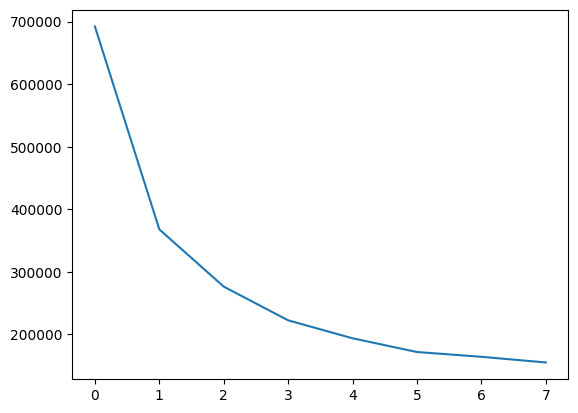

In [44]:
K = range(2,10)

cost = []

for num_clusters in K:
    kproto_elbow = KPrototypes(n_clusters=num_clusters, init='Cao', random_state=42)
    kproto_elbow.fit_predict(clustering_df, categorical=[0,3,4,5,7,8])
    cost.append(kproto_elbow.cost_)

plt.plot(cost)

Ao analisar o resultado, optou-se por utilizar três clusters.  
o código abaixo aplica o algorítmo aos dados com o parâmetro de cluster igual a 3.

In [45]:
kproto = KPrototypes(n_clusters=3, init='Cao', random_state=42)
kproto.fit_predict(clustering_df, categorical=[0,3,4,5,7,8])

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

Após gerados os clusters, esses são associados ao banco de dados para caracterização dos clientes que a eles pertencem.  
Uma amostra dos dados com o rótulo de qua cluster esses dados pertencem é apresentada.

In [46]:
original_merged_df['cluster'] = kproto.labels_
original_merged_df.head(2)

,account_id,order_origin,total_amount,subsidy_amount,city,dish_type,has_free_delivery,lag_last_order,ifood_status,ifood_status_last_month,total_order_count,cluster
0,00073adf-7117-44ba-90fe-5879c9581b68,RESTAURANT,2737.500,0.0,CURITIBA,Marmita,True,6.0,Active,Active,270,0
1,000b1fec-8616-4014-9581-c5a944911ac3,RESTAURANT,5368.125,0.0,RIO DE JANEIRO,Lanches,False,0.0,Active,Active,791,0


As variáveis numéricas são separadas das categóricas e agrupadas pelos clusters.
Tomou-se a decisão de calcular a mediana para cada uma das variáveis numéricas para reduzir a influência dos valores discrepantes.

In [47]:
original_merged_num_cols = ['total_amount','subsidy_amount', 'lag_last_order', 'total_order_count', 'cluster']
original_merged_num_df = original_merged_df[original_merged_num_cols]
original_merged_num_df.groupby(['cluster']).median()

,total_amount,subsidy_amount,lag_last_order,total_order_count
cluster,,,,
0,5558.75,0.00,1.5,345.0
1,4606.25,0.00,85.5,17.0
2,5236.25,498.75,715.0,16.0


As variáveis categóricas também foram agrupadas pelos clusters e aplicado o método describe para apresentar um resumo das informações.
Para melhor interpretabilidade, os dados foram transpostos.

In [48]:
original_cat_cols = list(set(original_merged_df.columns) - set(original_merged_num_cols))
original_cat_cols.append('cluster') 
original_merged_df[original_cat_cols].drop('account_id', axis=1).groupby('cluster').describe().T

cluster                                  0           1                  2
city                    count        13449         314                  9
                        unique         232          22                  3
                        top      SAO PAULO   SAO PAULO          SAO PAULO
                        freq          6247         168                  5
order_origin            count        13449         314                  9
                        unique           3           3                  1
                        top     RESTAURANT  RESTAURANT         RESTAURANT
                        freq         13233         307                  9
ifood_status_last_month count        13449         314                  9
                        unique           4           4                  3
                        top         Active    Inactive             Active
                        freq         10514         147                  3
ifood_status            count        13449         314                  9
                        unique           4           4                  3
                        top         Active    Inactive             Active
                        freq          8792         154                  4
dish_type               count        13449         314                  9
                        unique          55          29                  6
                        top        Lanches     Lanches  Comida Brasileira
                        freq          3948          96                  3
has_free_delivery       count        13449         314                  9
                        unique           2           2                  2
                        top          False        True               True
                        freq          7334         178                  7

Abaixo são apresentados os três tipos de comida preferidos para cada cluster.

In [54]:
print('cluster 0:')
print(original_merged_df[original_merged_df['cluster'] == 0]['dish_type'].value_counts(ascending=False).head(3))

print('cluster 1:')
print(original_merged_df[original_merged_df['cluster'] == 1]['dish_type'].value_counts(ascending=False).head(3))

print('cluster 2:')
print(original_merged_df[original_merged_df['cluster'] == 2]['dish_type'].value_counts(ascending=False).head(3))

cluster 0:
dish_type
Lanches              3948
Comida Brasileira    2782
Pizza                1459
Name: count, dtype: int64
cluster 1:
dish_type
Lanches              96
Comida Brasileira    51
Pizza                48
Name: count, dtype: int64
cluster 2:
dish_type
Comida Brasileira    3
Lanches              2
Açaí                 1
Name: count, dtype: int64


In [59]:
sp_perc = ( original_merged_df[original_merged_df['city'] == 'SAO PAULO'].value_counts().sum() / original_merged_df.shape[0] ) * 100
print("São Paulo corresponde a {:.2f}% das cidades dos clientes".format(sp_perc))

São Paulo corresponde a 46.62% das cidades dos clientes


#### Conclusões  
A seguir são apresentadas as características de cada cluster:

**Cluster 0:**  
Esse é o cluster mais ativo na plataforma, realizando pedidos semanalmente (1,5 dias entre pedidos) e o que mais gasta com pedidos (5558.75 U.M.). Esse grupo não leva em consideração os cupons de desconto na hora da compra, assim como a taxa de entrega grátis também não parece ser determinante. Apresenta preferência para seguintes tipos de comida: lanches, comida brasileira e pizza. destacando-se lanches, sendo a preferência de 3948 clientes.

**Cluster 1:**  
 É o grupo que tem o gasto mais baixo comparado aos demais (4606.25 U.M.) e a frequência entre pedidos é de 85,5 dias. Esse grupo também não leva em consideração os cupons de desconto na hora da compra, assim como o cluster 0, mas a taxa de entrega grátis mostra-se um fator de decisão importante, sendo a escolha mais comum de 178 clientes do total de 314. Já a preferência para os tipos de comida são lanches, comida brasileira e pizza.

**Cluster 2:**  
Por fim, o cluster 2 é o que apresenta um gasto intermediário (5236.25 U.M.), porém a frequência de uso da plataforma é muito baixa, cerca de um pedido a cada 715 dias. Esse grupo busca por cupons de desconto na hora da compra e a taxa de entrega grátis é um fator importante. A preferência  é pelos tipos de comida: comida brasileira, lanche e açai. Cabe ressaltar, que o número de observações deste grupo é muito pequeno (n=9), o que pode causar distorções na interpretação de algumas variáveis, como é o caso de “ifood_status” e “ifood_status_last_month”, em que mesmo possuindo um intervalo grande entre pedidos (mediana de 715 dias), os clientes aparecem como ativos na plataforma, como se estivessem realizando pedidos mensalmente.

Como características comuns entre os três clusters formados, o tipo de propaganda que mais funciona na plataforma é o de restaurantes. A cidade de São Paulo destacou-se por ser a cidade com mais comum entre os clientes, correspondendo a 46,62%.